In [32]:
import jax
from position2 import Position2
from dataclasses import dataclass, field
import numpy as np
import matplotlib.pyplot as plt
from math import *
import scipy.interpolate
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn

# Load SLAM data

In [2]:
# datafile = "/media/mikhail/Data3T/slam_benchmark/intel.clf"
datafile = "/home/mikhail/Downloads/intel.gfs(4).log" # Corrected intel map

In [46]:
@dataclass(frozen=True)
class LaserData(object):
    ranges: np.array
    angles: np.array
    timestamp: float
    odometry_position: Position2
        
    def as_points(self):
        mask = self.ranges < 10
        x = self.ranges[mask] * np.cos(self.angles[mask])
        y = self.ranges[mask] * np.sin(self.angles[mask])
        return np.stack([x, y], axis=1)

    def as_points_in_odometry_frame(self):
        points = self.as_points()
        return self.odometry_position.apply(points)

In [44]:
laser_data_list = []
with open(datafile, "r") as fd:
    for line in fd.readlines():
        line = line.strip()
        tokens = line.split(' ')
        if len(tokens) <= 180:
            continue
        num_scans = int(tokens[1])
        ranges = np.array([float(r) for r in tokens[2:(num_scans + 2)]])
        angles = np.linspace(-90.0 / 180.0 * np.pi, 90.0 / 180.0 * np.pi, num_scans + 1)[:-1]
        timestamp = float(tokens[(num_scans + 8)])
        odom_x, odom_y, odom_theta = [float(r) for r in tokens[(num_scans + 2):(num_scans + 5)]]
        position = Position2(odom_x, odom_y, odom_theta)
        laser_data_list.append(LaserData(ranges=ranges, angles=angles, timestamp=timestamp, odometry_position=
                                        position))

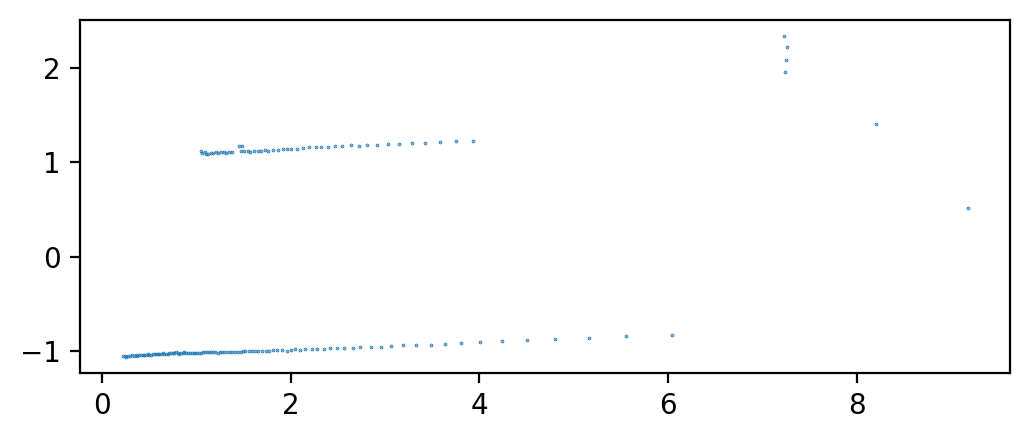

In [5]:
plt.figure(dpi=200)
all_points = []
for laser_data in laser_data_list[:1]:
    all_points.append(laser_data.as_points_in_odometry_frame())
points = np.concatenate(all_points, axis=0)
plt.scatter(points[:, 0], points[:, 1], s=0.1)
plt.gca().set_aspect('equal')

## Load ground truth

In [6]:
@dataclass
class StampedTrajectory():
    trajectory: Position2
    times: np.array
    
    def interpolate(times):
        result = scipy.interpolate.interp1d(self.times, self.trajectory, kind="linear", axis=0, 
                                            fill_value="extrapolate")(times)
        return result

# Rendering

In [95]:
class NFModel(nn.Module):
    mean: float
    sigma: float

    @nn.compact
    def __call__(self, x):
        x = (x - self.mean) / self.sigma
        x = nn.Dense(256)(x)      
        x = jnp.concatenate([jnp.sin(x[:, :128]), jnp.cos(x[:, 128:])], axis=1)
        x1 = x
        x1 = nn.Dense(128)(x1)
        x1 = nn.relu(x1)
        x1 = nn.Dense(128)(x1)
        x1 = nn.relu(x1)
        x1 = nn.Dense(128)(x1)
        x1 = nn.relu(x1)
        x = jnp.concatenate([x, x1], axis=-1)
        x = nn.Dense(1)(x)
        return x[:, 0]


In [96]:
def plot_model_heatmap(model, variables):
    grid_x, grid_y = jnp.meshgrid(jnp.linspace(0, 3, 100), jnp.linspace(0, 3, 100))
    grid = jnp.stack([grid_x, grid_y], axis=2).reshape(-1, 2)
    obstacle_probabilites = jax.nn.softplus(model.apply(variables, grid))
    obstacle_probabilites = np.array(obstacle_probabilites).reshape(100, 100)
    grid = grid.reshape(100, 100, 2)
    plt.gca().pcolormesh(grid[:, :, 0], grid[:, :, 1], obstacle_probabilites, cmap='RdBu', shading='auto')
    plt.gca().set_aspect('equal')

In [97]:
model = NFModel(0, 0.1)
batch = jnp.ones([10, 2])
variables = model.init(jax.random.PRNGKey(0), batch)
output = model.apply(variables, batch)

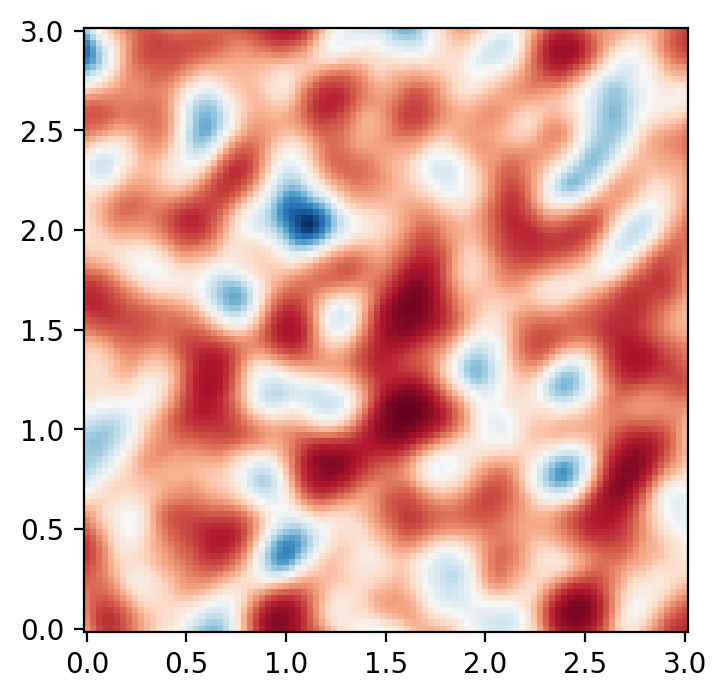

In [98]:
plt.figure(dpi=200)
plot_model_heatmap(model, variables)

In [115]:
# def loss(variables, batch):
#     return jnp.sum(model.apply(variables, batch))
# print(jax.make_jaxpr(jax.grad(loss))(variables, batch))

In [156]:
import functools
import jax.random

In [50]:
@dataclass(unsafe_hash=True)
class ModelConfig(object):
    minimal_depth: float
    maximal_depth: float
    bins_count: int
    depth_delta: float = field(init=False)
    def __post_init__(self):
        self.depth_delta = (self.maximal_depth - self.minimal_depth) / self.bins_count

In [237]:
@jax.jit
def calculate_weights(densities, depth_deltas):
    mis_probability = jnp.exp(-densities * depth_deltas)
    hit_probability = 1 - mis_probability
    mis_probability = jnp.concatenate([jnp.ones(1), mis_probability])
    hit_probability = jnp.concatenate([hit_probability, jnp.ones(1)])
    cumproduct = jnp.cumprod(mis_probability)
    weights = cumproduct * hit_probability
    return weights

@functools.partial(jax.jit, static_argnums=1)
def sample_depth_bins(uniform, parameters):
    depths = jnp.linspace(parameters.minimal_depth, parameters.maximal_depth, parameters.bins_count + 1)[:-1]
    depths = depths + parameters.depth_delta * uniform
    return jnp.concatenate([jnp.full([depths.shape[0], 1], parameters.minimal_depth), 
                            depths, 
                            jnp.full([depths.shape[0], 1], parameters.maximal_depth)], axis=-1)

@jax.jit
def transform_points(points, x, y, angle):
    transformed_x = x + points[..., 0] * jnp.cos(angle) - points[..., 1] * jnp.sin(angle)
    transformed_y = x + points[..., 0] * jnp.sin(angle) + points[..., 1] * jnp.cos(angle)
    return jnp.stack([transformed_x, transformed_y], axis=-1)


def calculate_points(depths, angles):
    x = depths * jnp.cos(angles[..., None])
    y = depths * jnp.sin(angles[..., None])
    return jnp.stack([x, y], axis=-1)
    
@functools.partial(jax.jit, static_argnums=7)
def loss(variables, truth_depths, angles, uniform, x, y, angle, config):
    depth_bins = sample_depth_bins(uniform, config)
    depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
    depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
    points = calculate_points(depths, angles).reshape(-1, 2)
    print(depths.shape)
    densities = jax.nn.softplus(model.apply(variables, points)).reshape(depths.shape[:2])
    weights = jax.vmap(calculate_weights)(densities, depth_deltas)
    extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
    predicted_depths = jnp.sum(weights * extended_depths, axis=-1)
    predicted_variance = jnp.sum(weights * (extended_depths - predicted_depths[..., None]) ** 2, axis=-1)
    predicted_variance = np.array(predicted_variance, copy=True)
    return (truth_depths - predicted_depths) ** 2 / predicted_variance
    
#     product = 1
#     densities = torch.logsumexp(torch.cat([torch.zeros_like(densities)[None], densities[None]], dim=0), dim=0)
    
#     for i in range(len(depths)):
#         if i < len(depths) - 1:
#             depth_delta = depths[i + 1] - depths[i]
#         else:
#             depth_delta = self._default_depth - depths[i]
#         hit_probability = 1 - torch.exp(-densities[i] * depth_delta)
#         weights.append(hit_probability * product)
#         product = product * (1 - hit_probability)
#     weights.append(product)
#     return torch.stack(weights, dim=0)

In [238]:
config = ModelConfig(
    minimal_depth=1,
    maximal_depth=4,
    bins_count=5
)

In [239]:
loss(variables, truth_depths=jnp.ones(10), angles=jnp.ones(10), uniform=jnp.ones([10, 5]), x=jnp.ones(10), y=jnp.ones(10), angle=jnp.ones(10), config=config)

(10, 6)


TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=0/1)>
While tracing the function loss at /tmp/ipykernel_2307776/2395805713.py:31 for jit, this concrete value was not available in Python because it depends on the values of the argument passed at flattened positions [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13].
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [134]:
jnp.ones(2).copy()

array([1., 1.], dtype=float32)

In [135]:
jax.vmap(transform_points, in_axes=(0, 0, 0, 0))(jnp.ones([10, 10, 2]), jnp.ones([10]), jnp.ones([10]), jnp.ones([10]))

DeviceArray([[[0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ]],

             [[0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ]],

             [[0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732

In [130]:
transform_points(jnp.ones([10, 10, 2]), jnp.ones([10, 1]), jnp.ones([10, 1]), jnp.ones([10, 1]))

DeviceArray([[[0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ]],

             [[0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ]],

             [[0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732 ],
              [0.69883126, 2.3817732

In [131]:
jax.vmap(functools.partial(sample_depth, parameters=config))(jnp.ones([4, config.bins_count]) * 0.5)

DeviceArray([[1. , 1.5, 2.5, 3.5, 4. ],
             [1. , 1.5, 2.5, 3.5, 4. ],
             [1. , 1.5, 2.5, 3.5, 4. ],
             [1. , 1.5, 2.5, 3.5, 4. ]], dtype=float32)

In [125]:
jnp.cumprod(jnp.array([3, 2, 3, 4]))

DeviceArray([ 3,  6, 18, 72], dtype=int32)

In [118]:
a = jnp.array([1, 2, 3])
b = np.array([1, 2, 3])
              
calculate_weights(a, b)

DeviceArray([6.3212049e-01, 3.6114153e-01, 6.7371167e-03, 8.3152884e-07],            dtype=float32)

In [16]:
batch = np.ones([3, 20, 30])
jax.vmap(jax.vmap(calculate_weights))(batch, batch)

DeviceArray([[[6.3212049e-01, 2.3254415e-01, 8.5548222e-02, ...,
               4.3707469e-13, 1.6079081e-13, 9.3576527e-14],
              [6.3212049e-01, 2.3254415e-01, 8.5548222e-02, ...,
               4.3707469e-13, 1.6079081e-13, 9.3576527e-14],
              [6.3212049e-01, 2.3254415e-01, 8.5548222e-02, ...,
               4.3707469e-13, 1.6079081e-13, 9.3576527e-14],
              ...,
              [6.3212049e-01, 2.3254415e-01, 8.5548222e-02, ...,
               4.3707469e-13, 1.6079081e-13, 9.3576527e-14],
              [6.3212049e-01, 2.3254415e-01, 8.5548222e-02, ...,
               4.3707469e-13, 1.6079081e-13, 9.3576527e-14],
              [6.3212049e-01, 2.3254415e-01, 8.5548222e-02, ...,
               4.3707469e-13, 1.6079081e-13, 9.3576527e-14]],

             [[6.3212049e-01, 2.3254415e-01, 8.5548222e-02, ...,
               4.3707469e-13, 1.6079081e-13, 9.3576527e-14],
              [6.3212049e-01, 2.3254415e-01, 8.5548222e-02, ...,
               4.3707469e-13, 1.

In [100]:
model.apply(variables, jnp.ones([10, 2]))

DeviceArray([-0.03629278, -0.03629278, -0.03629278, -0.03629278,
             -0.03629278, -0.03629278, -0.03629278, -0.03629278,
             -0.03629278, -0.03629278], dtype=float32)